# Going deeper with layers

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/deep-learning-intro/">https://d9w.github.io/deep-learning-intro/</a><br>Based on the Supaero Data Science Deep Learning class: https://supaerodatascience.github.io/deep-learning/

In [5]:
import torch
import torchvision
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# <a id="sec1">1. Dataset: Fashion-MNIST</a>

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits but is more complex.

<img src="img/fashion-mnist-small.png">

In [6]:
labels_text = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

PyTorch comes with this dataset by default, but we need to download it. We'll then make dataloaders which lazily iterate through the datasets. We'll use a training set and a validation set and greatly reduce their sizes to make this notebook run in a reasonable time.

In [7]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

full_trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
trainset, full_validset = torch.utils.data.random_split(full_trainset, (10000, 50000))
validset, _ = torch.utils.data.random_split(full_validset, (1000, 49000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False, num_workers=2)

The test data should also be downloaded. We'll use it at the very end of this notebook to test our model.

In [8]:
testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

<div class="alert alert-success">
Exercise 2:
Download the Fashion-MNIST dataset and run the following code.
    
+ Why are there 4 images in our list?
+ Why does the list of images change every time we run the code?

</div>

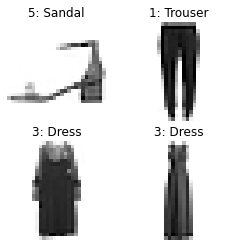

In [9]:
# get the first batch of images and labels
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(4,4))
for i in range(len(images)):
    l = labels[i].numpy()
    plt.subplot(2, 2, i+1)
    plt.title('%d: %s' % (l, labels_text[l]))
    plt.imshow(images[i].numpy()[0], cmap='Greys')
    plt.axis('off')

For the rest of today, we'll focus on creating a deep neural network that accurately classifies these images. This will highlight one application of deep learning, image processing, which has been highly successful. In upcoming classes, we'll see other examples of deep learning (GANs, LSTMs) which have different architectures and training rules. However, the basic principles remain the same!

# <a id="sec2">2. ANNs in Layers</a>

Last class, we looked at individual neurons organized in networks like this:

<img src="img/nn_fc.png" width="60%">

These two hidden layers are called "Fully Connected layers" because every neuron of these layers is connected to every neuron of the previous layer.

In PyTorch, Fully Connected layers are represented with the `torch.nn.Linear` function. The documentation is [here](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20linear#torch.nn.Linear) or we can ask Jupyter:

In [10]:
help(torch.nn.Linear)

Help on class Linear in module torch.nn.modules.linear:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features: int, out_features: int, bias: bool = True) -> None
 |  
 |  Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
 |        additional dimensions and :math:`H_{in} = \text{in\_features}`
 |      - Output: :math:`(N, *, H_{out})` where all but the last dimension
 |        are the same shape as the input and :math:`H_{out} = \text{out\_features}`.
 |  
 |  Attributes:
 |      weight: the learnable weights of the module of shape
 |          :math:`(\text{out\_features}, \t

Let's make a single fully connected layer:

In [11]:
from torch import nn
fc = nn.Linear(784, 10)

Let's use this layer as a network and construct a forward pass function. Our image data is 28 by 28, but we want it to match the layer dimensions. We'll transform the image from 28 by 28 to 1 by 784, and then pass the image through our fully connected layer.

In [12]:
def forward(x):
    x = x.view(-1, 28 * 28) # Transforms from (1, 28, 28) to (1, 784)
    x = fc(x) # Goes through fully connected layer
    return x # Output, 10 neurons

We'll take the maximum output as our label prediction. Let's see how this layer does - remember we haven't trained it, it's completely random.

In [13]:
for batch in range(3):
    images, labels = dataiter.next()
    for i in range(len(images)):
        outputs = forward(images[i])
        h = np.argmax(outputs.detach().numpy())
        y = labels[i]
        print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))

True: 9 Ankle boot, Predicted: 7 Sneaker
True: 3 Dress, Predicted: 1 Trouser
True: 2 Pullover, Predicted: 4 Coat
True: 1 Trouser, Predicted: 4 Coat
True: 2 Pullover, Predicted: 0 T-shirt/top
True: 2 Pullover, Predicted: 3 Dress
True: 3 Dress, Predicted: 0 T-shirt/top
True: 5 Sandal, Predicted: 4 Coat
True: 4 Coat, Predicted: 1 Trouser
True: 1 Trouser, Predicted: 1 Trouser
True: 4 Coat, Predicted: 4 Coat
True: 7 Sneaker, Predicted: 4 Coat


Let's double check that our fully connected layer is simply doing $$y = w^T x + b$$

In [14]:
a = (np.matmul(images[1].view(-1, 784), np.transpose(fc.weight.detach().numpy())) + fc.bias)[0].detach().numpy()
b = forward(images[1]).detach().numpy()
print('Numpy:\n', a)
print('PyTorch:\n', b)

Numpy:
 [ 0.14173557  0.6017529  -0.6165502  -0.31101364  0.16587903 -0.4258575
 -0.64971524  0.32233047 -0.2908937   0.25157008]
PyTorch:
 [[ 0.14173567  0.60175276 -0.6165502  -0.31101367  0.16587892 -0.42585754
  -0.64971524  0.32233045 -0.29089367  0.25157028]]


In [15]:
print(a == b, 'difference: ', np.sum((a-b)**2))

[[False False  True False False False  True False False False]] difference:  8.304468e-14


We have some slight errors due to floating point representation differences between PyTorch and numpy, but the calculation is the same!

In [16]:
fc1 = nn.Linear(784, 128)
fc2 = nn.Linear(128, 10)

In [17]:
def forward(x):
    x = x.view(-1, 28 * 28)
    x = fc1(x)
    x = fc2(x)
    return x

for i in range(len(images)):
    outputs = forward(images[i])
    h = np.argmax(outputs.detach().numpy())
    y = labels[i]
    print('True: %d %s, Predicted: %d %s' % (y, labels_text[y], h, labels_text[h]))


True: 4 Coat, Predicted: 0 T-shirt/top
True: 1 Trouser, Predicted: 0 T-shirt/top
True: 4 Coat, Predicted: 7 Sneaker
True: 7 Sneaker, Predicted: 0 T-shirt/top


We'll formalize our neural network functions in a `torch.nn.Module` class which creates the layers when initialized and then calculates the forward pass of the network with the function `forward(x)`.

In [18]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
net = SimpleNet()

Now that we have our network, we're ready to train it.

# <a id="sec3">3. Backpropagation and training</a>

So far, the way we've been using `torch` has been almost equivalent to `numpy`, and we've been calling `detach().numpy()` on `torch` objects to convert them to numpy arrays. We haven't yet taken advantage of the main benefit of `torch`: automatic differentiation. Let's look at that and see how it helps us train our neural network.

First, a bit of vocabulary. The objects we're working with, neural network weights and biases, are called `tensors`. 
<img src="img/tensor.png" width="50%">
A `tensor` is a generic term for a linear mapping of any linear mapping from one algeabraic object to another. A scalar is a single value, a vector a 1D object of values, a matrix a 2D object, and a tensor is an N-dimension object (scalars, vectors, and matrices are also tensors). In deep learning frameworks, tensors are the core computational object. We store all values in tensors and link them in computational graphs.

A torch tensor looks very much like a numpy object. We can compare a 2D torch tensor and a numpy matrix:

In [19]:
a = np.ones((2, 2))
b = torch.ones(2, 2)
print('Numpy: ', a)
print('Torch: ', b)
np.all(b.numpy() == a)

Numpy:  [[1. 1.]
 [1. 1.]]
Torch:  tensor([[1., 1.],
        [1., 1.]])


True

However, we can ask torch to keep track of the gradient of a tensor. As this tensor is used to compute other tensors, this will create a computational graph.

In [20]:
x = torch.ones(2, 2, requires_grad=True)
print('x: ', x)
y = (3 * x * x).mean()
print('y: ', y)
y.backward()
print('dy/dx: ', x.grad)

x:  tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y:  tensor(3., grad_fn=<MeanBackward0>)
dy/dx:  tensor([[1.5000, 1.5000],
        [1.5000, 1.5000]])


The gradient definition in `y` depends on the calculation of `x` and allows us to calculate `dy/dx` by calling `backward()`. This is known as automatic differentiation, as the gradients at each step in the computation are automatically calculated. If you want to go further in detail about this, check out the [autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

Let's use automatic differentiation to calculate the gradients of our neural network parameters. This will automatically perform backpropogation using the gradient definition at each function in our network.

In [21]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
onehot = torch.nn.functional.one_hot(labels, num_classes=10).float()

labels, onehot

(tensor([5, 6, 9, 9]),
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]))

`images` contains our batch of input, so calling `net` on it will perform a forward pass through the network. We'll then compare this to the onehot encoded label and compute the Mean Squared Error.

In [22]:
net = SimpleNet()
outputs = net(images)
print('Outputs ', outputs)
loss = torch.sum((outputs - onehot) ** 2, 1).mean()
print('Loss ', loss)

Outputs  tensor([[-0.0027,  0.1120, -0.2667, -0.3588, -0.1618,  0.1832, -0.2392,  0.2357,
         -0.2873, -0.3023],
        [ 0.2078, -0.0399, -0.2768, -0.3472, -0.4094,  0.1123, -0.1620, -0.0499,
          0.0894, -0.0844],
        [ 0.0520,  0.5061, -0.1276, -0.3730, -0.2053,  0.1837, -0.1307,  0.2736,
         -0.2084, -0.0698],
        [ 0.0813,  0.8049, -0.0682, -0.4399, -0.1671,  0.2788,  0.0178,  0.1677,
         -0.0895, -0.3298]], grad_fn=<AddmmBackward>)
Loss  tensor(1.8789, grad_fn=<MeanBackward0>)


Now that we've calculated the error, we can backpropagate it using `backward()`. We first set all the gradients to zero, and then we'll observe how the gradients of the second layer's bias change.

In [23]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('fc2.bias.grad before backward')
print(net.fc2.bias.grad)

loss.backward()

print('fc2.bias.grad after backward')
print(net.fc2.bias.grad)

fc2.bias.grad before backward
None
fc2.bias.grad after backward
tensor([ 0.1692,  0.6916, -0.3697, -0.7594, -0.4718, -0.1210, -0.7571,  0.3135,
        -0.2479, -1.3932])


We can use this gradient calculation to update the neural network weights:
$$w_{ij} \leftarrow w_{ij} - \alpha \left(f_\theta(x) - y\right) \delta_j x_{ij}$$

In [24]:
print('fc2.bias before training')
print(net.fc2.bias.data)

learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

print('fc2.bias after training')
print(net.fc2.bias.data)

fc2.bias before training
tensor([-0.0743, -0.0452, -0.0485, -0.0448, -0.0821,  0.0457, -0.0019,  0.0825,
        -0.0381,  0.0341])
fc2.bias after training
tensor([-0.0760, -0.0521, -0.0448, -0.0372, -0.0774,  0.0469,  0.0057,  0.0794,
        -0.0356,  0.0480])


Torch provides loss functions and optimizers that we can use instead of writing our own. For now, we'll use the `torch.nn.CrossEntropyLoss` and `torch.optim.SGD` functions.

Just one last thing before we train on the full dataset: we're calculting the gradients at every batch, not at every data point. This is an expensive gradient calculation, so let's reduce the number of times we do it by increasing the batch size. This has the benefit of reducing overfitting by computing the gradient over a large sample of images.

In [25]:
def train(net):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

In [26]:
net = SimpleNet()
%time train_loss = train(net)
print(train_loss)

CPU times: user 2.15 s, sys: 19.4 ms, total: 2.17 s
Wall time: 2.37 s
43.33738315105438


To see how our network performs, we'll apply it to the validation set.

In [27]:
def get_valid_predictions(net):
    validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False)
    all_labels = np.array([])
    predictions = np.array([])
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, labels.numpy())
            predictions = np.append(predictions, predicted.numpy())
    return all_labels, predictions

In [28]:
y_valid, predictions = get_valid_predictions(net)

In [29]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy: ', accuracy_score(predictions, y_valid))
print(classification_report(predictions, y_valid, target_names=labels_text))

Accuracy:  0.394
              precision    recall  f1-score   support

 T-shirt/top       0.04      0.57      0.08         7
     Trouser       0.96      0.44      0.60       227
    Pullover       0.19      0.32      0.24        66
       Dress       0.33      0.29      0.31       129
        Coat       0.48      0.38      0.43       124
      Sandal       0.67      0.29      0.40       228
       Shirt       0.00      0.00      0.00        11
     Sneaker       0.25      0.24      0.25       105
         Bag       0.40      0.95      0.56        43
  Ankle boot       0.56      0.90      0.69        60

    accuracy                           0.39      1000
   macro avg       0.39      0.44      0.35      1000
weighted avg       0.56      0.39      0.43      1000



# <a id="sec4">4. Activation Functions</a>

So far, our network is a chain of $$ Y = w^T x+b $$ However, in the last class, the neurons we modeled used sigmoid functions: $$ Y = \sigma(w^T x+b) $$ Let's apply this to our current network and see how it changes training. Torch has two ways to do this: define a `torch.nn.Sigmoid` layer or apply the `torch.nn.functional.sigmoid` function (`torch.sigmoid` in future versions). We'll use the functional method.

In [30]:
import torch.nn.functional as F

class SigmoidNet(nn.Module):
    def __init__(self):
        super(SigmoidNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = SigmoidNet()

In [31]:
total_loss = train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))

/home/d9w/.venvs/38/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy:  0.098


## Rectified Linear Units (ReLU)

We'll now look at a different activation function, the ReLU. Remember the shape of the sigmoid activation function?

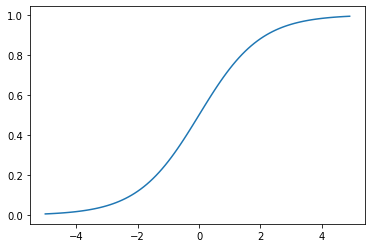

In [32]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

XX = np.arange(-5,5.,0.1)
plt.plot(XX,sigmoid(XX));

Let's plot the gradient of this function.

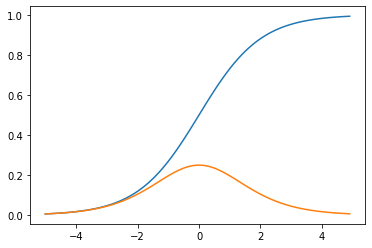

In [33]:
def sigmoid_der(x):
    y = sigmoid(x)
    return y*(1.-y)

XX = np.arange(-5,5.,0.1)
plt.plot(XX,sigmoid(XX));
plt.plot(XX,sigmoid_der(XX));

Do you remember that during backpropagation, the $\delta_j$ were recursively obtained by:
$$\delta_j = \sigma'(y_j) \sum_{l\in L_j} \delta_l w_{jl}$$

This poses a major problem when the networks become deeper: at each layer, we multiply our gradients by $\sigma'(y_j)$ which is much smaller than 1. So the gradient we want to back-propagate shrinks to zero and all our weight updates become zero.

This is called the **vanishing gradient** problem.

To avoid this problem, we introduce a new type of activation function: the Rectified Linear Unit (ReLU).
$$\sigma(y) = \max\{0,y\}$$

The key property of this function is that its derivative is either zero or one.

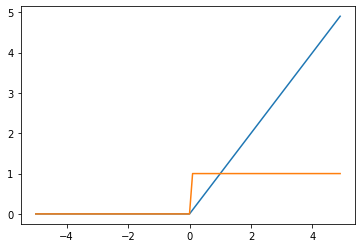

In [34]:
def relu(x):
    return np.maximum(0.,x)
def relu_der(x):
    return relu(x) > 0

plt.plot(XX,relu(XX));
plt.plot(XX,relu_der(XX));

**Caveat of using ReLU activation functions**

Although they allow us to train deep networks, ReLU functions have their downsides.
- Unbounded values: the output of a layer is not bounded anymore, causing possible divergence.
- Dying ReLU neurons: the backpropagation of gradients can push the input weigths towards values such that $\sigma(y)=0$ all the time. Then all future backpropagations will leave these weights unchanged: the neuron is dead.

Some advanced methods can compensate these weaknesses but are out of the scope of this introduction.

In torch, the ReLU activation function is either a layer `torch.nn.ReLU` or a function in `torch.nn.functional.relu`.

In [35]:
class ReLUNet(nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = ReLUNet()
train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))


Accuracy:  0.417
